# **Facial Emotion Recognition System**

In [2]:
#importing all libraries
import pandas as pd
import numpy as np
import os
from PIL import Image
import cv2
from collections import Counter
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Input, Dense, Dropout, BatchNormalization
import tensorflow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix


In [3]:
# Load the CSV file
data_path = pd.read_csv("/kaggle/input/emotion-recognition-dataset/data.csv")

# Define the base path for images
base_image_path = "/kaggle/input/emotion-recognition-dataset/dataset"

In [4]:
images = []
labels = []
img_dim = 224

In [5]:
def preprocess_image(img):
    # Resize to 224x224 pixels
    img = img.resize((img_dim, img_dim))
    # Convert to np.array
    img = np.array(img)
    # Convert image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Smooth image by Gaussian Blur
    img = cv2.GaussianBlur(img,(3,3), 0)
    return img


In [6]:
def load_and_process_image(image_path):
    # Correct path construction
    full_path = os.path.join(base_image_path, image_path)
    try:
        with Image.open(full_path) as img:
            img = preprocess_image(img)
            return np.array(img)  # Convert the PIL image to a NumPy array
    except IOError as e:
        print(f"Error opening {full_path}: {e}")  # Print error if image cannot be opened
        return None

In [7]:
for _, row in data_path.iterrows():
    if (row['label'] != "Ahegao"):  # Make sure this emotion is excluded
        img = load_and_process_image(row['path'])
        if img is not None:
            images.append(img)
            labels.append(row['label'])
        else:
            print(f"Failed to load image: {row['path']}")  # Debug output for failed loads


Loaded 14248 images and 14248 labels.


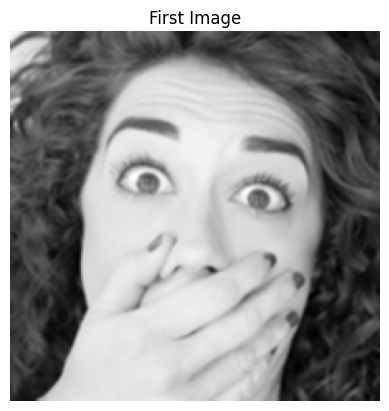

Sample labels: ['Surprise' 'Surprise' 'Surprise' 'Surprise' 'Surprise' 'Surprise'
 'Surprise' 'Surprise' 'Surprise' 'Surprise']


In [8]:
# Convert lists to NumPy arrays if any images were loaded
if images:
    images = np.array(images)
    images = images.astype(np.uint8)
    labels = np.array(labels)
    
    print(f"Loaded {len(images)} images and {len(labels)} labels.")
    plt.imshow(images[0], cmap='gray')  # Display the first image
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.title('First Image')
    plt.show()
    # Example: Display some labels
    print("Sample labels:", labels[:10])
else:
    print("No images or labels to display.")


In [9]:
#randomise images 

#before shuffle
print("Labels before shuffle:", labels[:10])

indices = np.arange(images.shape[0])
np.random.seed(10)  # Same order of indices every time
np.random.shuffle(indices) 

# Use the shuffled indices to reorder your arrays
images = images[indices]
labels = labels[indices]

#after shuffle
print("Labels after shuffle:", labels[:10])


Labels before shuffle: ['Surprise' 'Surprise' 'Surprise' 'Surprise' 'Surprise' 'Surprise'
 'Surprise' 'Surprise' 'Surprise' 'Surprise']
Labels after shuffle: ['Neutral' 'Neutral' 'Happy' 'Sad' 'Sad' 'Angry' 'Surprise' 'Surprise'
 'Sad' 'Happy']


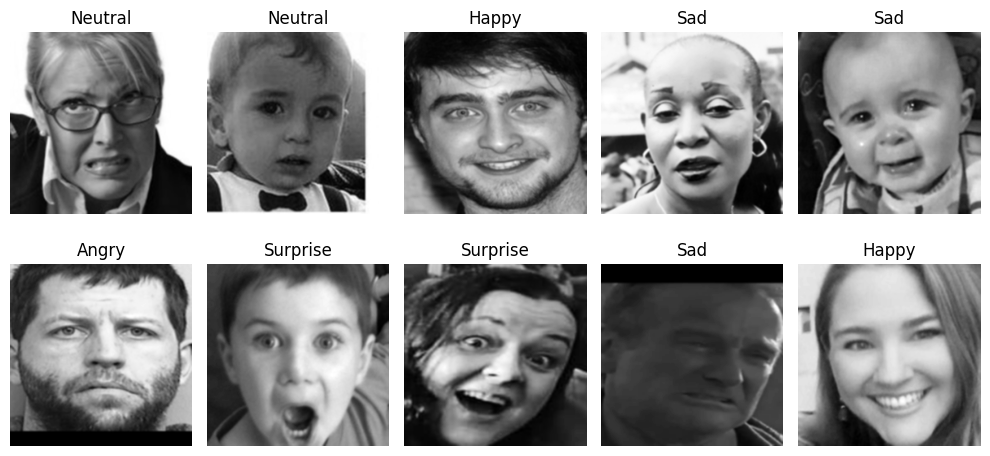

In [10]:
def show_images_grid(images, labels, num_images=10):
    """Display a grid of images with their labels."""
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(labels[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_images_grid(images, labels)



In [22]:
# Add 3rd dimension
print(images.shape)
expanded_images = []
for i in range(len(images)):
    tmp = np.expand_dims(images[i],axis=2)
    expanded_images.append(np.array(tmp))
expanded_images = np.array(t1)
images = expanded_images
print(images.shape)

(14248, 224, 224)
(14248, 224, 224, 1)


In [11]:
# Perform One Hot Encoding for labels
labels_df = pd.DataFrame(labels, columns=['Emotion'])
one_hot_labels = pd.get_dummies(labels_df['Emotion'])

one_hot_labels.head()
# Now `one_hot_labels` can be used as the target variable for machine learning training


,Angry,Happy,Neutral,Sad,Surprise
0,False,False,True,False,False
1,False,False,True,False,False
2,False,True,False,False,False
3,False,False,False,True,False
4,False,False,False,True,False


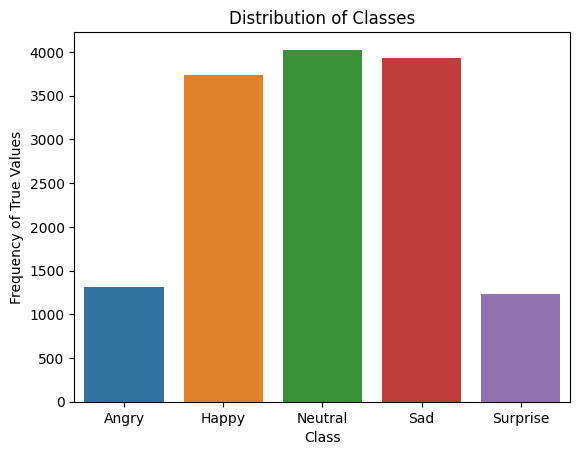

In [12]:
# Plot the distribution of classes.
def plot_class_distribution(labels):
    # Summing each column to get the number of true values per class
    class_sums = labels.sum(axis=0)
    
   # Plotting using seaborn
    sns.barplot(x=class_sums.index, y=class_sums.values)
    plt.title("Distribution of Classes")
    plt.xlabel("Class")
    plt.ylabel("Frequency of True Values")
    plt.show()

# one_hot_labels for data representation
plot_class_distribution(one_hot_labels)


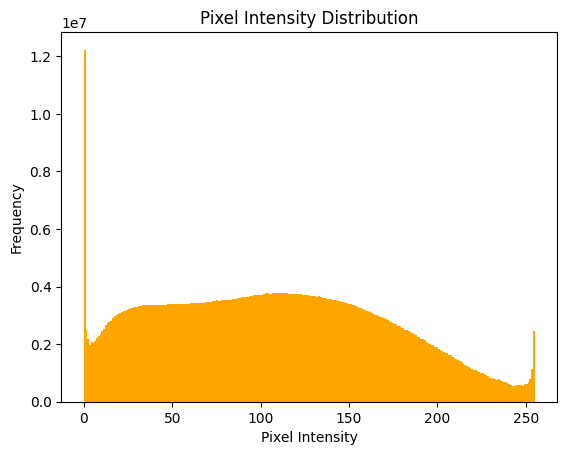

In [13]:
# Plot histogram of pixel intensities.
def plot_pixel_distribution(images):
    
    plt.hist(images.ravel(), bins=256, color='orange', )
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title('Pixel Intensity Distribution')
    plt.show()

plot_pixel_distribution(images)


In [14]:
# Split the data into training, testing and validation sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, stratify=labels, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.6, stratify=y_test, random_state=42)

def check_distribution(labels, set_name):
    unique, counts = np.unique(labels, return_counts=True)
    print(f"Distribution in {set_name} set:")
    for label, count in zip(unique, counts):
        print(f"Label {label}: {count} ({100 * count / len(labels):.2f}%)")
    print("\n")
        
check_distribution(labels, "Total")
check_distribution(y_train, "Training")
check_distribution(y_test, "Test")
check_distribution(y_val, "Validation")

#show_images_grid(X_train, y_train)
#show_images_grid(X_test, y_test)

Distribution in Total set:
Label Angry: 1313 (9.22%)
Label Happy: 3740 (26.25%)
Label Neutral: 4027 (28.26%)
Label Sad: 3934 (27.61%)
Label Surprise: 1234 (8.66%)


Distribution in Training set:
Label Angry: 1050 (9.21%)
Label Happy: 2992 (26.25%)
Label Neutral: 3222 (28.27%)
Label Sad: 3147 (27.61%)
Label Surprise: 987 (8.66%)


Distribution in Test set:
Label Angry: 105 (9.21%)
Label Happy: 299 (26.23%)
Label Neutral: 322 (28.25%)
Label Sad: 315 (27.63%)
Label Surprise: 99 (8.68%)


Distribution in Validation set:
Label Angry: 158 (9.24%)
Label Happy: 449 (26.26%)
Label Neutral: 483 (28.25%)
Label Sad: 472 (27.60%)
Label Surprise: 148 (8.65%)




In [16]:
# Normalize data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_val = X_val.astype('float32') / 255
#X_train = X_train.reshape(-1, 128, 128, 3)
#X_test = X_test.reshape(-1,128,128,3)

X_train.shape

(11398, 224, 224)

In [59]:

# Calculate the maximum number of samples per class
max_samples_per_class = 2000

# Calculate the number of samples to keep for each class
class_labels, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(class_labels, counts))

# Calculate the minimum number of samples per class based on the maximum
class_ratios = {cls: min(max_samples_per_class, count) for cls, count in class_counts.items()}

#reshape X_train to 2D
num_samples, img_height, img_width, num_channels = X_train.shape
print(num_samples, img_height, img_width, num_channels)
X_train_reshaped = X_train.reshape(num_samples, img_dim * img_dim * num_channels)

# Undersample the dataset
rus = RandomUnderSampler(sampling_strategy=class_ratios, random_state=42)
undersampled_X_train, undersampled_y_train = rus.fit_resample(X_train_reshaped, y_train)

#reshape X_train to 3D
undersampled_X_train = undersampled_X_train.reshape(undersampled_X_train.shape[0], img_dim,img_dim,1)

# Shuffle the undersampled data
indices = np.arange(undersampled_X_train.shape[0])
np.random.seed(10)  # Same order of indices every time
np.random.shuffle(indices)

# Use the shuffled indices to reorder your arrays
undersampled_X_train = undersampled_X_train[indices]
undersampled_y_train = undersampled_y_train[indices]

#check distribution and shuffle on undersampled dataset
check_distribution(undersampled_y_train, 'Undersampled')
show_images_grid(undersampled_X_train, undersampled_y_train)


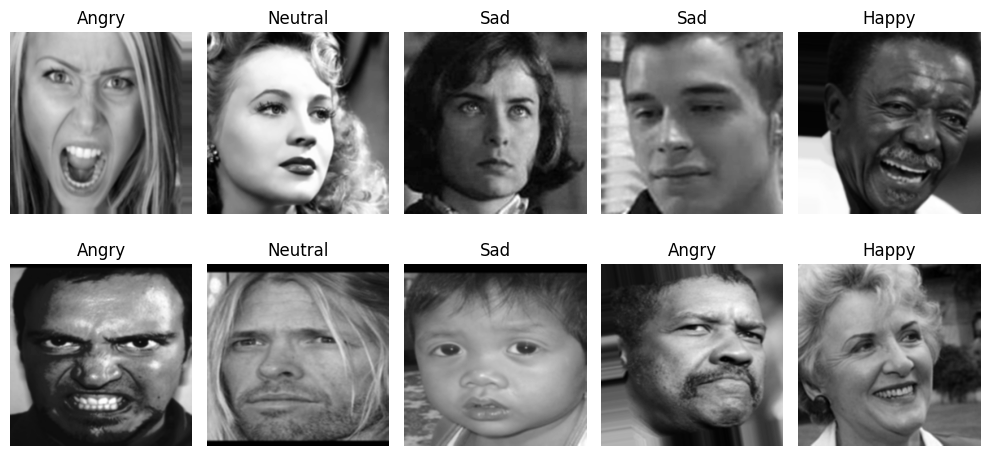

(11398, 224, 224) (17500, 224, 224, 1)


In [17]:
# Augment Images
def augment_images(X_train, y_train, target_count):
    # Create an instance of ImageDataGenerator with desired augmentations
    data_gen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')


    # Determine how many images each label needs
    unique_labels, counts = np.unique(y_train, return_counts=True)
    label_to_count = dict(zip(unique_labels, counts))

    augmented_images = []
    augmented_labels = []

    # Process each label
    for label in unique_labels:
        count = label_to_count.get(label, 0)
        if count < target_count:
            # How many additional images are needed
            additional_needed = target_count - count
             # Filter images of the current label from training set
            images_to_augment = X_train[y_train == label]
            images_to_augment = images_to_augment.reshape(images_to_augment.shape[0], img_dim, img_dim, 1)

            # Image Generation
            images_generated = 0
            while images_generated < additional_needed:
                # Generate batch of augmented images
                batch = next(data_gen.flow(images_to_augment, batch_size=32, shuffle=False))
                num_to_add = min(len(batch), additional_needed - images_generated)
                augmented_images.extend(batch[:num_to_add])
                augmented_labels.extend([label] * num_to_add)
                images_generated += num_to_add

    # Convert lists to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    #show_images_grid(augmented_images, augmented_labels)  

    # Check if X_train needs to be reshaped to include the channel dimension
    if X_train.ndim == 3:
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    # Combine original and augmented data
    X_train_augmented = np.concatenate([X_train, augmented_images], axis = 0)
    y_train_augmented = np.concatenate([y_train, augmented_labels], axis = 0)

    # Shuffle the dataset
    X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented)

    return X_train_augmented, y_train_augmented

# Use the function
X_train_augmented, y_train_augmented = augment_images(X_train, y_train, 3500)

#Check augmented training set
show_images_grid(X_train_augmented, y_train_augmented)

print(X_train.shape, X_train_augmented.shape)

In [21]:
#check augmented training set
check_distribution(y_train_augmented, 'Augmented')
check_distribution(y_test, "Test")
check_distribution(y_val, "Validation")


(1140, 224, 224) (1710, 224, 224)


In [22]:
print(X_test.shape, X_val.shape)
X_test = np.expand_dims(X_test, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
print(X_test.shape, X_val.shape)

(1140, 224, 224) (1710, 224, 224)
(1140, 224, 224, 1) (1710, 224, 224, 1)


In [30]:
#encode labels
print(X_train.dtype)
print(y_train.dtype)

print("Sample labels:", y_train[:10])

# Create a label encoder object
encoder = LabelEncoder()

# Fit the encoder to the training data and transform it to integers
y_train_encoded = encoder.fit_transform(y_train_augmented)
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = encoder.fit_transform(y_test)
y_test_encoded = to_categorical(y_test_encoded)
y_val_encoded = encoder.fit_transform(y_val)
y_val_encoded = to_categorical(y_val_encoded)
print(y_test_encoded.dtype, y_train_encoded.dtype, y_val_encoded.dtype)
print(X_train_augmented.dtype, X_test.dtype, X_val.dtype)

print("Encoded labels sample:\n", y_train_encoded[:10])


float64 float64 float64
float32 float32 float32


In [37]:
print(y_test_encoded.dtype, y_train_encoded.dtype, y_val_encoded.dtype)
print(X_train_augmented.dtype, X_test.dtype, X_val.dtype)
print(X_train_augmented.shape, X_test.shape, X_val.shape)


float64 float64 float64
float32 float32 float32
(17500, 224, 224, 1) (1140, 224, 224, 1) (1710, 224, 224, 1)


In [51]:
#simple model
def build_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation = 'relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation = 'relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation = 'relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [52]:
input_shape = (img_dim, img_dim, 1) 
num_classes = 5

# Call the function to create the model
model = build_model(input_shape=input_shape, num_classes=num_classes)

# Now compile the model with the optimizer, loss function, and metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 346112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    44,302,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,395,781 (169.36 MB)

 Trainable params: 44,395,781 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Implement Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [54]:
# Train model with the one-hot encoded labels
history = model.fit(
    X_train_augmented, y_train_encoded,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val_encoded),
    callbacks=[early_stopping]  # Pass the early stopping callback to the fit method
)


Epoch 1/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 48s 120ms/step - accuracy: 0.3098 - loss: 1.6526 - val_accuracy: 0.4684 - val_loss: 1.2789
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 24s 87ms/step - accuracy: 0.4876 - loss: 1.2512 - val_accuracy: 0.5269 - val_loss: 1.1180
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 24s 87ms/step - accuracy: 0.5631 - loss: 1.0816 - val_accuracy: 0.5608 - val_loss: 1.0645
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 24s 87ms/step - accuracy: 0.6195 - loss: 0.9322 - val_accuracy: 0.5895 - val_loss: 0.9858
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 24s 87ms/step - accuracy: 0.6762 - loss: 0.8067 - val_accuracy: 0.5971 - val_loss: 0.9632
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - accuracy: 0.7143 - loss: 0.7000 - val_accuracy: 0.5778 - val_loss: 1.0286
Epoch 7/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - accuracy: 0.7704 - loss: 0.5830 - val_accuracy: 0.6047 - val_loss: 1.0535
Epoch 8/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - accuracy: 0.8113 - loss: 0.4783 -

In [55]:
model.evaluate(X_test, y_test_encoded)

10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6652 - loss: 0.9311

W0000 00:00:1715026667.662802      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6272 - loss: 0.9727


[0.9652160406112671, 0.6175438761711121]

In [56]:
from sklearn.metrics import classification_report

# Assuming y_true are the true labels and y_pred are the predicted labels
# Use your model to predict probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert y_test_encoded to integer labels if needed
y_true = np.argmax(y_test_encoded, axis=1)

# Generate classification report
print(classification_report(y_true, y_pred))

#for i in range(100):
 #   print(f"Actual: {y_true[i]}, Predicted: {y_pred[i]}")


11/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

W0000 00:00:1715026673.720673      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
              precision    recall  f1-score   support

           0       0.42      0.46      0.44       105
           1       0.78      0.80      0.79       299
           2       0.65      0.55      0.59       322
           3       0.53      0.61      0.57       315
           4       0.56      0.48      0.52        99

    accuracy                           0.62      1140
   macro avg       0.59      0.58      0.58      1140
weighted avg       0.62      0.62      0.62      1140



In [57]:
# Initialize dictionaries to store counts
correct_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
wrong_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

# Iterate over predictions and actual classes
for actual, predicted in zip(y_true, y_pred):
    if actual == predicted:
        correct_counts[actual] += 1
    else:
        wrong_counts[actual] += 1

# Print counts for each class
for class_label in range(5):
    print(f"Class {class_label}: Correct = {correct_counts[class_label]}, Wrong = {wrong_counts[class_label]}")


Class 0: Correct = 48, Wrong = 57
Class 1: Correct = 239, Wrong = 60
Class 2: Correct = 177, Wrong = 145
Class 3: Correct = 192, Wrong = 123
Class 4: Correct = 48, Wrong = 51


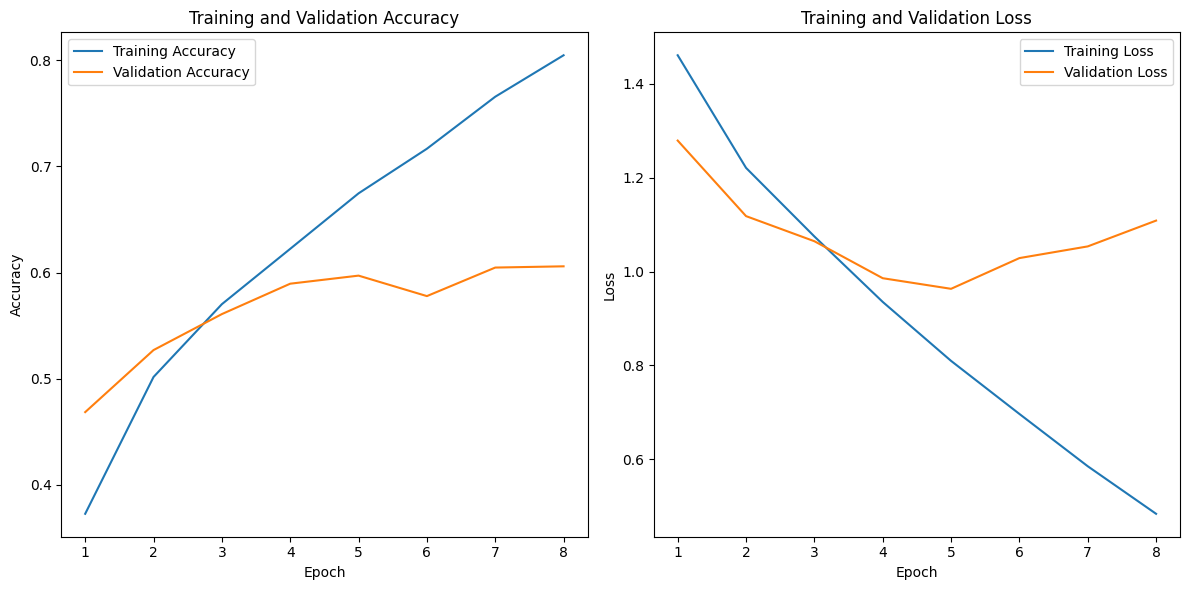

In [58]:

# Get the training and validation accuracy and loss from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()



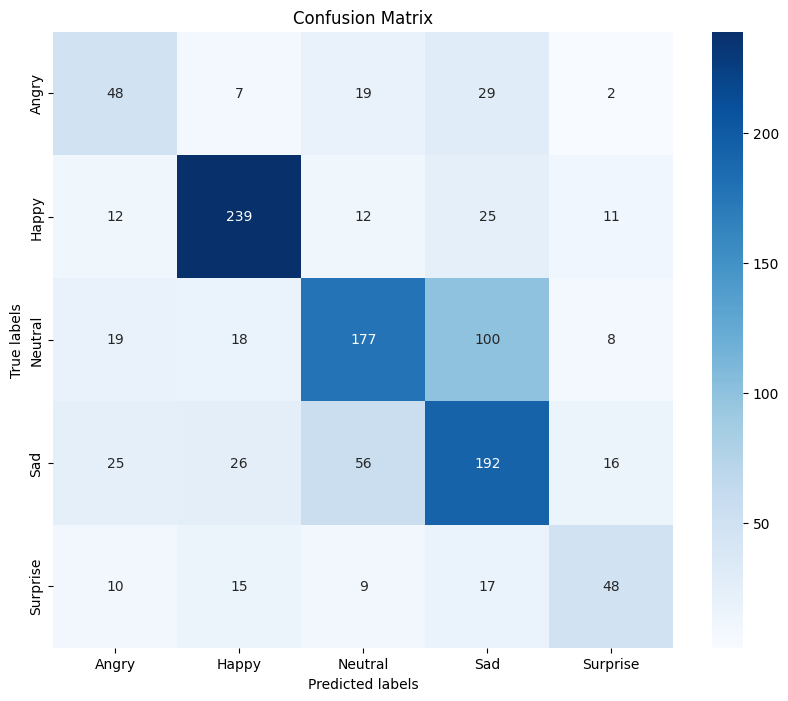

In [65]:
matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [62]:
model.save("Emotion_Recognition_model.h5")

In [2]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/working/Emotion_Recognition_model.h5')
